## House rent prediction using random forest algorithem

This project is to build machine learing model to predict the rent of houses based on the variables describing features of residential houses.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score


In [2]:
# importing house rent dataset
data = pd.read_csv('F:/SLIIT/4th Year/Semester 01/Machine Learning/Assingment 02/dataset/houseRent/housing_train.csv')
# displaying the first five rows of dataset
data.head()

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7039061606,https://bham.craigslist.org/apa/d/birmingham-h...,birmingham,https://bham.craigslist.org,1195,apartment,1908,3,2.0,1,...,0,0,0,laundry on site,street parking,https://images.craigslist.org/00L0L_80pNkyDeG0...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al
1,7041970863,https://bham.craigslist.org/apa/d/birmingham-w...,birmingham,https://bham.craigslist.org,1120,apartment,1319,3,2.0,1,...,0,0,0,laundry on site,off-street parking,https://images.craigslist.org/00707_uRrY9CsNMC...,Find Your Way to Haven Apartment Homes Come ho...,33.3755,-86.8045,al
2,7041966914,https://bham.craigslist.org/apa/d/birmingham-g...,birmingham,https://bham.craigslist.org,825,apartment,1133,1,1.5,1,...,0,0,0,laundry on site,street parking,https://images.craigslist.org/00h0h_b7Bdj1NLBi...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al
3,7041966936,https://bham.craigslist.org/apa/d/birmingham-f...,birmingham,https://bham.craigslist.org,800,apartment,927,1,1.0,1,...,0,0,0,laundry on site,street parking,https://images.craigslist.org/00808_6ghZ8tSRQs...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al
4,7041966888,https://bham.craigslist.org/apa/d/birmingham-2...,birmingham,https://bham.craigslist.org,785,apartment,1047,2,1.0,1,...,0,0,0,laundry on site,street parking,https://images.craigslist.org/00y0y_21c0FOvUXm...,Apartments In Birmingham AL Welcome to 100 Inv...,33.4226,-86.7065,al


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265190 entries, 0 to 265189
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       265190 non-null  int64  
 1   url                      265190 non-null  object 
 2   region                   265190 non-null  object 
 3   region_url               265190 non-null  object 
 4   price                    265190 non-null  int64  
 5   type                     265190 non-null  object 
 6   sqfeet                   265190 non-null  int64  
 7   beds                     265190 non-null  int64  
 8   baths                    265190 non-null  float64
 9   cats_allowed             265190 non-null  int64  
 10  dogs_allowed             265190 non-null  int64  
 11  smoking_allowed          265190 non-null  int64  
 12  wheelchair_access        265190 non-null  int64  
 13  electric_vehicle_charge  265190 non-null  int64  
 14  come

In [4]:
## Data Cleaning
# Getting appropriate data types

In [5]:
# Removing decimal value from the baths attrtibute which is a float data type and it has some decimal values
# Changing float dtype of baths attributes to int64 after removing the decimal values
data['baths'] = np.ceil(data['baths'])
data['baths'] = data['baths'].astype(np.int64)

In [6]:
# adding missing values in categorial variables
# list of categorial variables that has missing values
cat_var = ['parking_options','laundry_options']

In [7]:
def imputeMissingCategory(data,var,modeof):
    return data.groupby(modeof)[var].transform(
        lambda x: x.fillna(x.mode()[0]))

In [8]:
# adding data to missing values in the categorial variables
data['parking_options'] = imputeMissingCategory(data,'parking_options','type')
data['laundry_options'] = imputeMissingCategory(data,'laundry_options','type')
data = data.dropna(subset=['state','description'],axis=0)

In [9]:
# adding missing values in numarical variables
# list of numarical variables that has missing values
num_var = ['lat','long']

In [10]:
def imputeMissingNumarical(data,var,meanof):
    return data.groupby(meanof)[var].transform(
        lambda x: x.fillna(x.mode()[0]))

In [11]:
# adding data to missing values in the numarical variables
data['lat'] = imputeMissingNumarical(data,'lat','region')
data['long'] = imputeMissingNumarical(data,'long','region')

In [12]:
# Cheking if there any missing values in dataset
naData = (data.isnull().sum()/len(data)) * 100
naData = naData.drop(naData[naData == 0].index).sort_values(ascending=False)
missingData = pd.DataFrame({'Missing Data Ratio': naData})
missingData.head()


,Missing Data Ratio


In [13]:
# Removing Outliers according to the upper and lower bound
priceUpper,priceLower = 2500, 1
sqFeetUpper,sqFeetLower = 1765, 1
bedsUpper,bedsLower = 5 , 1
bathsUpper,bathsLower = 5, 1

data = data[(data['sqfeet'] <= sqFeetUpper) & (data['sqfeet'] >= sqFeetLower)]
data = data[(data['baths'] <= bathsUpper) & (data['baths'] >= bathsLower)]
data = data[(data['price'] <= priceUpper) & (data['price'] >= bedsLower)]
data = data[(data['beds'] <= bedsUpper) & (data['beds'] >= bedsLower)]

In [14]:
# Adding more features to dataset
data['luxuryhouse'] = np.where((data['beds'] <= data['baths']) & (data['beds'] > 1), 1, 0)
data['bedspersqfeet'] = data['beds'] / data['sqfeet']
data['bathsperbeds'] = data['baths'] / data['beds']

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236038 entries, 1 to 265188
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       236038 non-null  int64  
 1   url                      236038 non-null  object 
 2   region                   236038 non-null  object 
 3   region_url               236038 non-null  object 
 4   price                    236038 non-null  int64  
 5   type                     236038 non-null  object 
 6   sqfeet                   236038 non-null  int64  
 7   beds                     236038 non-null  int64  
 8   baths                    236038 non-null  int64  
 9   cats_allowed             236038 non-null  int64  
 10  dogs_allowed             236038 non-null  int64  
 11  smoking_allowed          236038 non-null  int64  
 12  wheelchair_access        236038 non-null  int64  
 13  electric_vehicle_charge  236038 non-null  int64  
 14  come

In [16]:
# Transforming the positive numarical variables in order to get more Gaussian-like distribution. it will help the linear model
for cat in ['sqfeet', 'bedspersqfeet','price','bathsperbeds']:
    data[cat] = np.log(data[cat])

In [17]:
# Chenking dataset to make sure there is no any null value after transformation
[var for var in ['sqfeet', 'bedspersqfeet','price','bathsperbeds'] if data[var].isnull().sum() > 0]

[]

In [18]:
# Grouping the categorial variables that are present less then one present of observations.
# Those houses that has categorical variables less then one present wiill replace with string 'Rare'. 
# list of some categorial variables
catVars = ['region', 'type', 'laundry_options', 'parking_options', 'state']

frequentList = {
    'region': 
        ['denver', 'fayetteville', 'jacksonville', 'omaha / council bluffs', 'rochester'],
     'type': 
        ['apartment', 'condo', 'duplex', 'house', 'manufactured', 'townhouse'],
     'laundry_options': 
        ['laundry in bldg', 'laundry on site', 'w/d hookups', 'w/d in unit'],  
     'parking_options': 
        ['attached garage', 'carport', 'detached garage', 'off-street parking', 'street parking'],
     'state': 
        ['al', 'ar', 'az', 'ca', 'co', 'ct', 'fl', 'ga', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 
        'ma', 'md', 'mi', 'mn', 'ms', 'nc', 'nd', 'ne', 'nj', 'nm', 'nv', 'ny', 'oh']
}


for var in catVars:
    data[var] = np.where(data[var].isin(
        frequentList[var]), data[var], 'Rare')

In [19]:
# This function will transfrom the strings of categorial variables into numbers
def replaceCategories(data, var, target):

    ordered_labels = data.groupby([var])[target].mean().sort_values().index
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}
    data[var] = data[var].map(ordinal_label)

In [20]:
# Transforming the string values into numbers of categorial variables that are in the catVars list
for var in catVars:
    replaceCategories(data, var, 'price')

In [21]:
# Copying the data as new dataset with the apporiate attributes
features = ['region', 'price', 'type', 'sqfeet', 'smoking_allowed', 'wheelchair_access', 
            'electric_vehicle_charge', 'comes_furnished', 'laundry_options', 'parking_options','lat', 'long', 
            'luxuryhouse', 'bedspersqfeet', 'bathsperbeds']

cleanedData = data[features].copy()
cleanedData.head()

,region,price,type,sqfeet,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,lat,long,luxuryhouse,bedspersqfeet,bathsperbeds
1,3,7.021084,3,7.184629,1,0,0,0,1,0,33.3755,-86.8045,0,-6.086017,-0.405465
2,3,6.715383,3,7.032624,1,0,0,0,1,1,33.4226,-86.7065,0,-7.032624,0.693147
3,3,6.684612,3,6.831954,1,0,0,0,1,1,33.4226,-86.7065,0,-6.831954,0.000000
4,3,6.665684,3,6.953684,1,0,0,0,1,1,33.4226,-86.7065,0,-6.260537,-0.693147
5,3,6.802395,3,7.168580,1,0,0,0,1,1,33.4226,-86.7065,1,-6.475433,0.000000


<AxesSubplot:xlabel='beds', ylabel='count'>

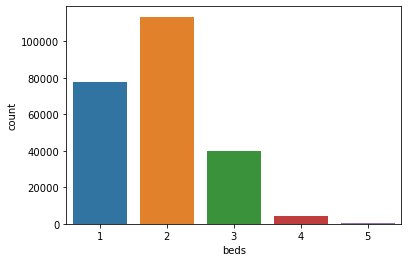

In [22]:
sns.countplot(data = data , x = 'beds')

<AxesSubplot:xlabel='baths', ylabel='count'>

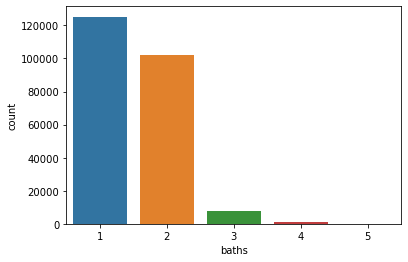

In [23]:
sns.countplot(data = data , x = 'baths')

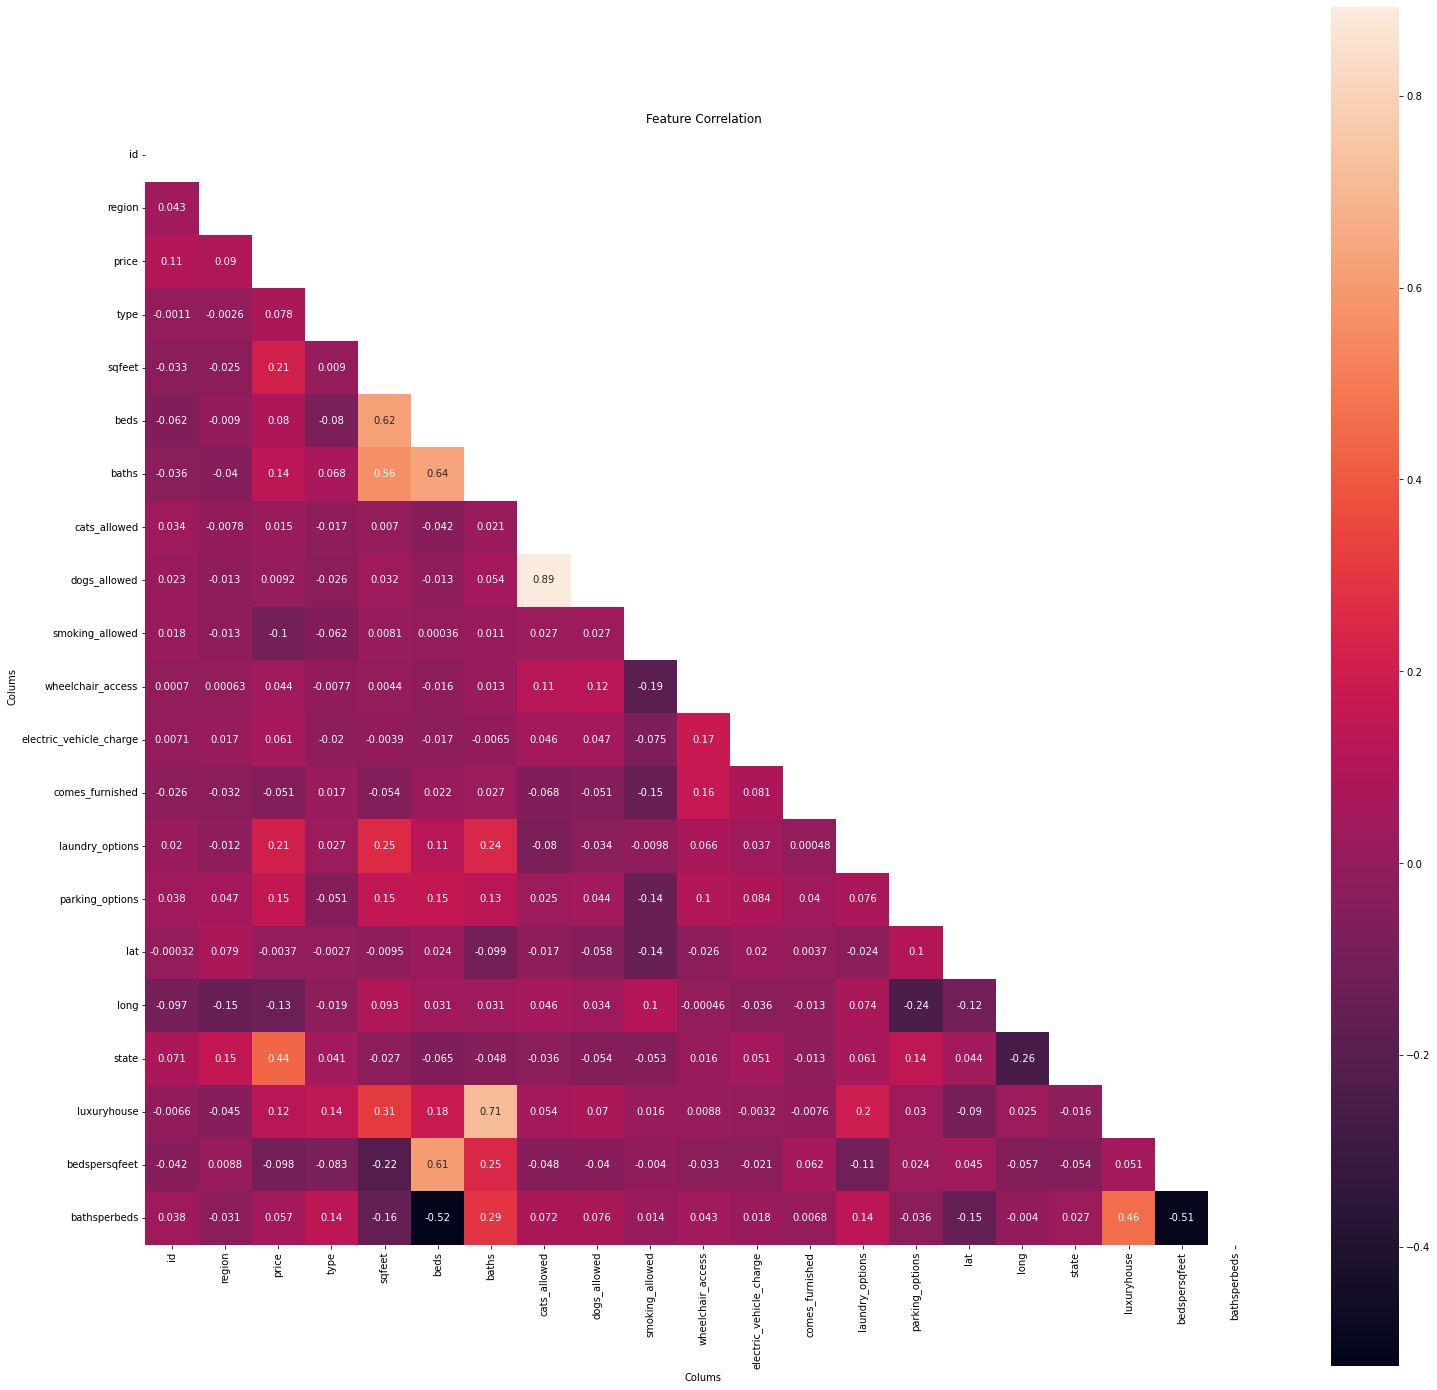

In [24]:
# Correlation Heatmap
corrMatrix = data.corr()
mask = np.zeros_like(corrMatrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

figure, axis = plt.subplots(figsize=(25,25))

sns.heatmap(corrMatrix, annot=True, square=True, fmt='.2g', mask=mask, ax=axis).set(
title = 'Feature Correlation', xlabel = 'Colums', ylabel = 'Colums')

axis.set_yticklabels(corrMatrix.columns, rotation = 0)
axis.set_xticklabels(corrMatrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [25]:
# We are dividing the dataset to test and training dataset
y = cleanedData['price']
X = cleanedData.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

print('Shape of training features:',X_train.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of test features:',X_test.shape)
print('Shape of test labels:',y_test.shape)

Shape of training features: (165226, 14)
Shape of training labels: (165226,)
Shape of test features: (70812, 14)
Shape of test labels: (70812,)


In [26]:
rf = RandomForestRegressor(random_state=101, n_estimators=200)

rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=101)

In [27]:
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=101, verbose=0, warm_start=False)

RandomForestRegressor(n_estimators=200, random_state=101)

In [28]:
rf_pred = rf.predict(X_test)

Mean Absolute Error: 0.060988369091586725
Root Mean Squared Error: 0.17254820957083425
R2 Score: 0.8792141098577937


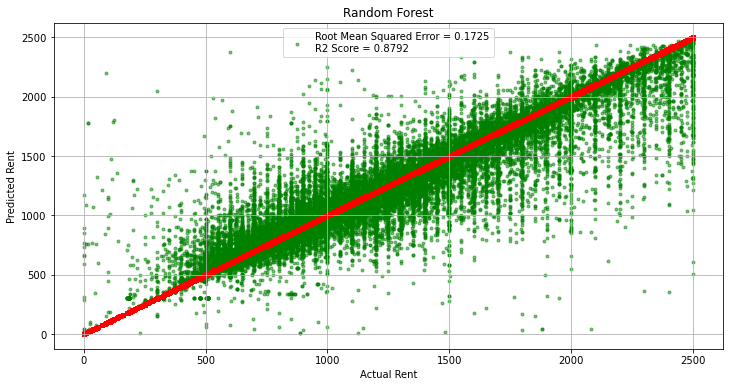

In [29]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test,rf_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,rf_pred)))
print('R2 Score:', metrics.r2_score(y_test,rf_pred))

pred = pd.DataFrame(data={'PredictedRent': np.exp(rf_pred), 'ActualRent': np.exp(y_test)})

figure = plt.figure(figsize=(12,6))
axis1 = figure.add_subplot(111)
axis1.scatter(pred['ActualRent'], pred['PredictedRent'], color='green', marker='.', label='Predicted', alpha=0.5)
axis1.scatter(pred['ActualRent'], pred['ActualRent'], s=10, color='red', marker='s', label='Actual')

plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.legend(['Root Mean Squared Error = {:.4f}\nR2 Score = {:.4f}'.format(
    np.sqrt(metrics.mean_squared_error(y_test,rf_pred)), metrics.r2_score(y_test,rf_pred))],
           loc = 'best')

plt.title('Random Forest')
plt.grid()
plt.show()